Необходимо понять, какой тариф выгоднее предложить клиенту: «Смарт» или «Ультра».

Описание данных:

- `calls` - количество звонков в месяц
- `minutes` - количество потраченных минут в месяц
- `messages` - количество сообщений в месяц
- `mb_used` - количество израсходованного трафика в мегабайтах в месяц
- `is_ultra` - тариф Ультра (1), тариф Смарт (0), наш целевой признак 

## 1. Загрузка и изучение данных

Импортируем необходимые нам библиотеки:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from IPython.display import display
import warnings

warnings.simplefilter("ignore") #будем игнорировать предупреждения


Откроем файл с данными и изучим его:

In [ ]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [ ]:
def info(data):
    print(display(data.head()))
    print(data.info())
    print('Дубликатов:', data.duplicated().sum())
    print(display(data.describe()))
    
    for column in data:
        if data[column].dtype == 'object':
            print('Признак:', column)
            print('Уникальные:', data[column].value_counts().count())
            print()

In [ ]:
info(data)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
Дубликатов: 0


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


None


Переведем столбцы `calls` и `messages` в целочисленный формат:

In [ ]:
data['calls'] = data['calls'].astype(int)
data['messages'] = data['messages'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null int64
minutes     3214 non-null float64
messages    3214 non-null int64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Мы видим следующие 5 признаков:
- `calls` - количество звонков в месяц
- `minutes` - количество потраченных минут в месяц
- `messages` - количество сообщений в месяц
- `mb_used` - количество израсходованного трафика в мегабайтах в месяц
- `is_ultra` - тариф Ультра (1), тариф Смарт (0), наш целевой признак 

Количество клиентов 3214. Пропущенных данных нет, дубликатов нет.

Посмотрим на статистики:

In [ ]:
def stat(row, data=data):
    mean = np.mean(data[row])
    var = np.var(data[row])
    std = np.std(data[row])
    print('Для {}:'.format(row))
    print('Среднее значение {:.3f}'.format(mean))
    print('Дисперсия  {:.3f}'.format(var))
    print('Стандартное отклонение  {:.3f}'.format(std))
    

In [ ]:
stat('calls')
print()
stat('minutes')
print()
stat('messages')
print()
stat('mb_used')

Для calls:
Среднее значение 63.039
Дисперсия  1104.312
Стандартное отклонение  33.231

Для minutes:
Среднее значение 438.209
Дисперсия  55005.905
Стандартное отклонение  234.533

Для messages:
Среднее значение 38.281
Дисперсия  1306.295
Стандартное отклонение  36.143

Для mb_used:
Среднее значение 17207.674
Дисперсия  57301725.848
Стандартное отклонение  7569.790


Изобразим гистограммы для наших признаков в разрезе тарифов и сравним их с нормальным распределением:

In [ ]:
def histogram(row, data= data, titl='', rang=(0,0)):
    plt.figure(figsize = (6,4))   
    if rang ==(0,0):
        rang = (data[row].min(), data[row].max())
    n, bins, patches = plt.hist(data[row], bins=100, range =rang, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
      
    n = n.astype('int') # it MUST be integer
    # Good old loop. Choose colormap of your taste
    for i in range(len(patches)):
        patches[i].set_facecolor(plt.cm.plasma_r(n[i]/max(n)))
    # Make one bin stand out   
    
    patches[47].set_alpha(1) # Set opacity
    if titl =='':
        titl = 'Гистограмма распределения '+row
    # Add title and labels with custom font sizes
    plt.title(titl, fontsize=12)
    plt.xlabel(row)
    plt.ylabel('count')
    plt.show()

In [ ]:
def form(row, data = data):
    fig, ax = plt.subplots(1, 1, figsize = (6,4))
    data[row].plot(kind = 'kde', color ='k', alpha = 0.8)
    
    x = range(int(data[row].min()), int(data[row].max()))
    
    norm1 = st.norm.pdf(x,data[row].mean(),data[row].std())
    ax.plot(x, norm1, 'c--', alpha = 0.8)
    plt.legend([row, 'Нормальное'])
    plt.title('Вид распределения (пунктир - нормальное)')
    plt.xlabel(row)
    plt.show()

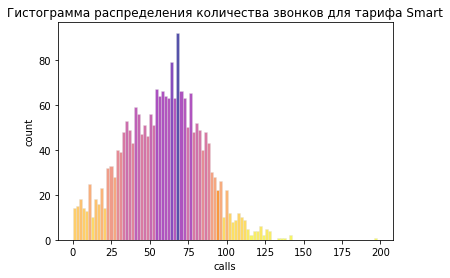

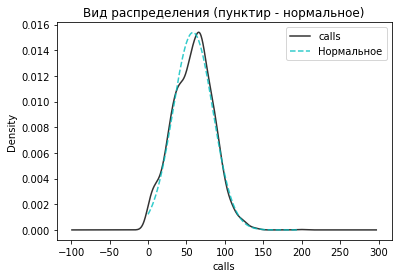

In [ ]:
histogram('calls', data = data.query('is_ultra ==0'), titl ='Гистограмма распределения количества звонков для тарифа Smart')
form('calls', data = data.query('is_ultra ==0'))

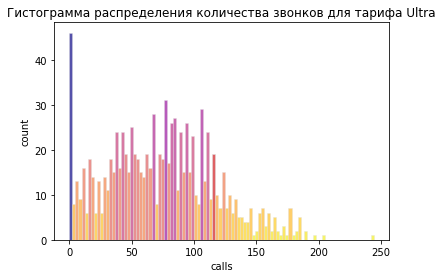

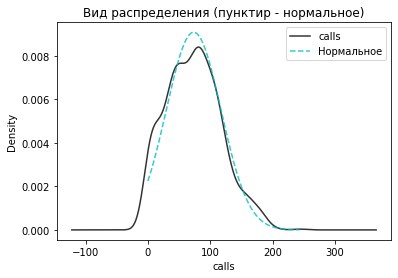

In [ ]:
histogram('calls', data = data.query('is_ultra ==1'), titl ='Гистограмма распределения количества звонков для тарифа Ultra')
form('calls', data = data.query('is_ultra ==1'))

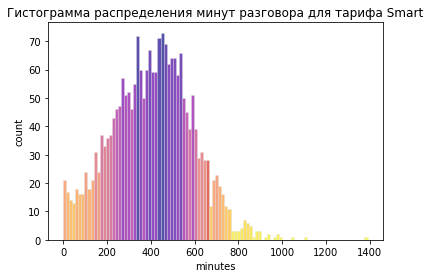

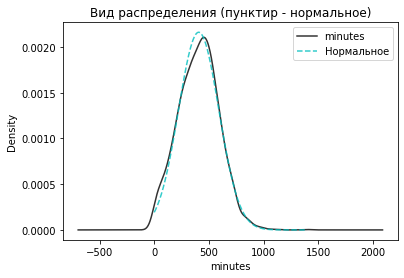

In [ ]:
histogram('minutes', data = data.query('is_ultra ==0'), titl ='Гистограмма распределения минут разговора для тарифа Smart')
form('minutes', data = data.query('is_ultra ==0'))

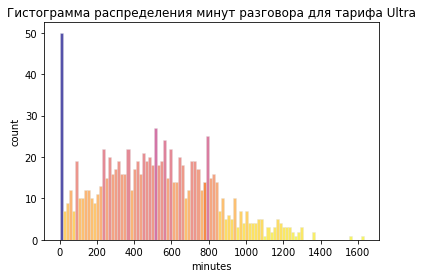

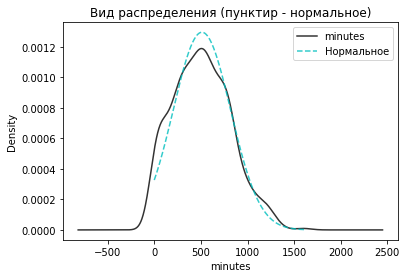

In [ ]:
histogram('minutes', data = data.query('is_ultra ==1'), titl ='Гистограмма распределения минут разговора для тарифа Ultra')
form('minutes', data = data.query('is_ultra ==1'))

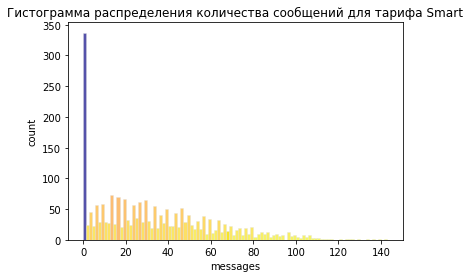

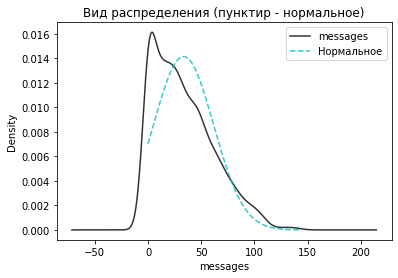

In [ ]:
histogram('messages', data = data.query('is_ultra ==0'), titl ='Гистограмма распределения количества сообщений для тарифа Smart')
form('messages', data = data.query('is_ultra ==0'))

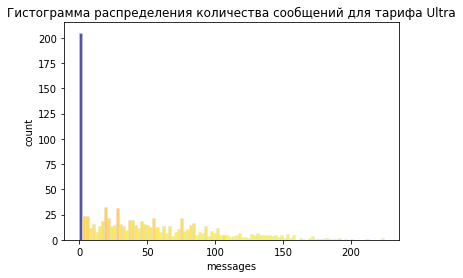

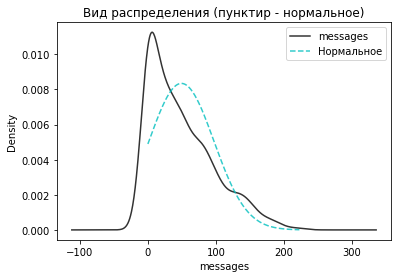

In [ ]:
histogram('messages', data = data.query('is_ultra ==1'), titl ='Гистограмма распределения количества сообщений для тарифа Ultra')
form('messages', data = data.query('is_ultra ==1'))

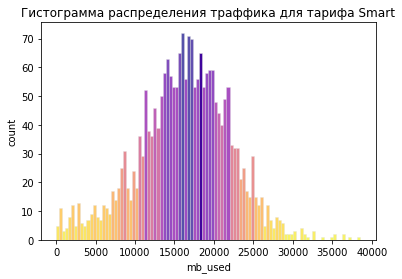

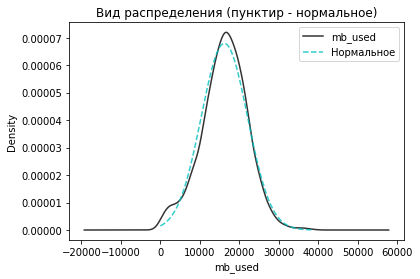

In [ ]:
histogram('mb_used', data = data.query('is_ultra ==0'), titl ='Гистограмма распределения траффика для тарифа Smart')
form('mb_used', data = data.query('is_ultra ==0'))

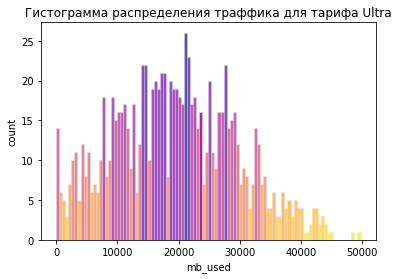

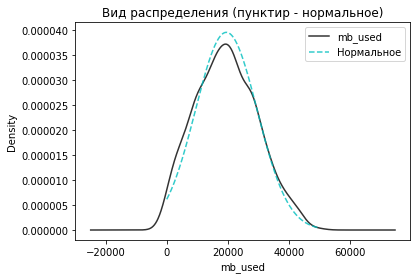

In [ ]:
histogram('mb_used', data = data.query('is_ultra ==1'), titl ='Гистограмма распределения траффика для тарифа Ultra')
form('mb_used', data = data.query('is_ultra ==1'))

Гистограммы распределения количества сообщений скошены вправо, остальные примерно напоминают нормальное рапределение.

Посмотрим на корреляции нашего целевого признака с прочими признаками:

In [ ]:
def ranking(y, title=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(5,5))
    #cmap = ['plasma']
    cmap = ListedColormap(sns.color_palette("plasma_r"))
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel('Корреляция')
    plt.ylabel('Признаки')
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(ch), xy=(ch if ch>0 else 0, p), va='center')

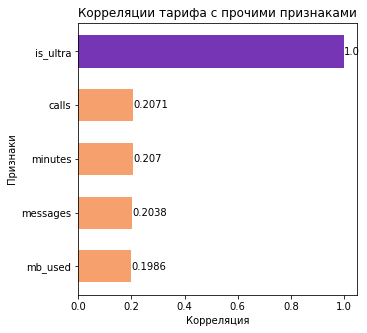

In [ ]:
ranking(data.corr()['is_ultra'].sort_values(ascending = False), 'Корреляции тарифа с прочими признаками')

Построим диаграмму отношений между всеми парами признаков:

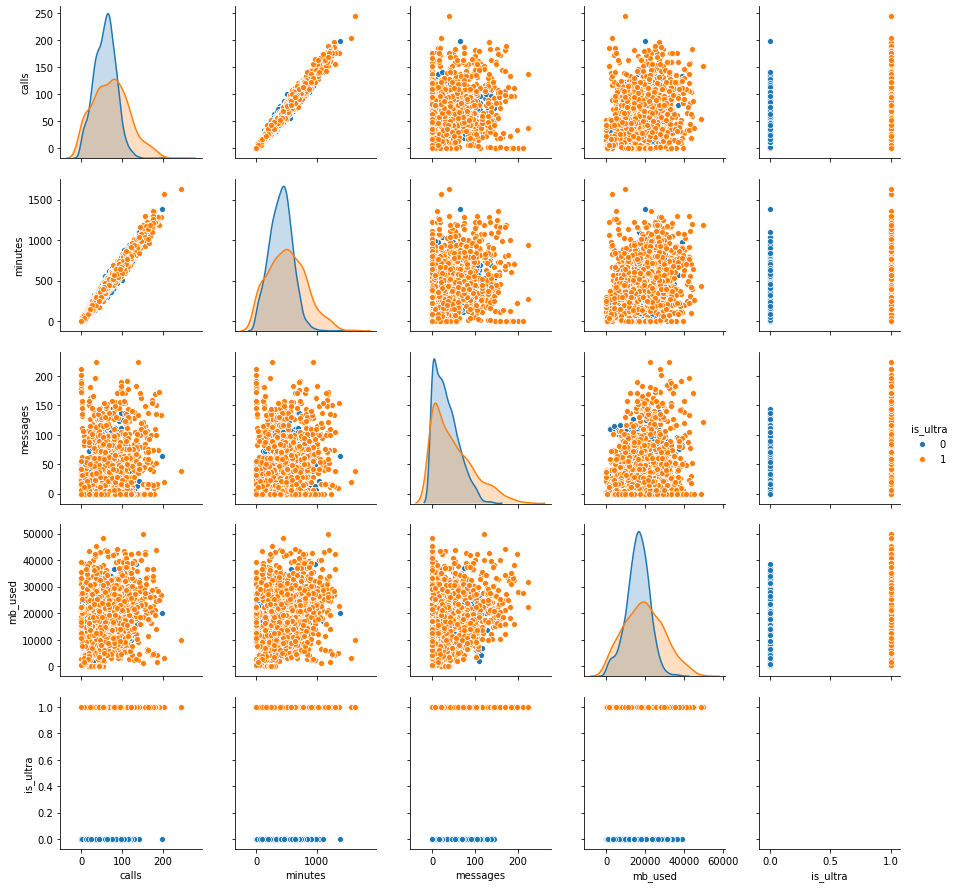

In [ ]:
sns.pairplot(data=data, hue="is_ultra")
plt.show()

<a id='section11'></a>

### Вывод

- Мы открыли и изучили файл с данными. Данные готовы к дальнейшей работе.
- Мы рассмотрели статистики всех признаков, гистограммы распределения всех признаков в разрезе тарифов, корреляции всех признаков с тарифом, построили диаграмму отношений между всеми парами признаков.

## 2. Разбиение данных на выборки

Сперва поделим наши данные на `features` (признаки) и `target` (целевой признак):

In [ ]:
features = data.drop('is_ultra', axis =1)
target = data['is_ultra']

Разобьем данные на выборки `train_val` и `test` в соотношении `8:2`, используя метод `train_test_split` из библиотеки `sklearn`:

In [ ]:
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.20, random_state=42)
print(features_train_val.shape, features_test.shape, target_train_val.shape, target_test.shape)

(2571, 4) (643, 4) (2571,) (643,)


Разобьем выборку `train_val` на `train` и `val` тем же методом в соотношении `8:2`:

In [ ]:
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.25, random_state=42)
print(features_train.shape, features_val.shape, target_train.shape, target_val.shape)

(1928, 4) (643, 4) (1928,) (643,)


### Вывод

- Мы отделили целевой признак от прочих признаков (`target` и `features`)
- Мы подготовили выборки: тренировочную `train`, валидационную `val` и тестовую `test`. Их соотношение `6:2:2`. Мы разбили выборки в таком соотношении, чтобы максимум возможного количества данных приходился на обучающую выборку, но валидационная и тестовая выборка также имели достаточное количество данных.

## 3. Исследование моделей

Мы будем решать задачу классификации. Попробуем решить ее с помощью разных моделей, предложив всем моделям разные параметры и выбрав наилучшие. 

Создадим заранее таблицу результатов и будем в нее записывать наши наилучшие параметры модели и метрику `accuracy_score`

In [ ]:
final = pd.DataFrame(columns = ['model', 'best_params', 'sample', 'accuracy_score'])

#### 3.1 - Дерево решений

Исследуем модель под названием "дерево решений". создадим модель дерева решений - `model_tree_1` :

In [ ]:
model_tree_1 = DecisionTreeClassifier(random_state = 42)

Вызовем справку по параметрам `model_tree_1`:

In [ ]:
help(model_tree_1)

Help on DecisionTreeClassifier in module sklearn.tree.tree object:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split

Запишем все параметры, которые мы хотим менять, в словарь `params_tree` (ключ - параметр, значения - его значения):

In [ ]:
params_tree = ({'criterion': ('gini', 'entropy'),
            'splitter': ('best', 'random'),
            'max_depth': (None, 1, 2, 3, 4, 5, 6),
            'min_samples_split': (2, 3, 4, 5),
            'min_samples_leaf': (1, 2, 3, 4, 5),
            'class_weight': (None, 'balanced'),
            'presort': (True, False)
           })

Подберем наилучшие параметры модели с помощью функции `GridSearchCV`, используя тренировочную выборку:

In [ ]:
greed_tree = GridSearchCV(model_tree_1, params_tree)
greed_tree.fit(features_train, target_train)
greed_tree.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'presort': True,
 'splitter': 'best'}

Мы получили наилучшие пораметры для нашего дерева решений. Подставим их в наше дерево решений:

In [ ]:
model_tree_1.set_params(**greed_tree.best_params_)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=42, splitter='best')

Запустим обучение на тренировочной выборке:

In [ ]:
model_tree_1.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=42, splitter='best')

Посчитаем метрику `accuracy_score`, которой будем пользоваться в нашей задаче для сравнения результатов:

In [ ]:
preds = model_tree_1.predict(features_val)
accuracy_score(target_val, preds)

0.7822706065318819

Запишем результаты в финальную таблицу:

In [ ]:
final.loc[0]= ['model_tree_1', greed_tree.best_params_, 'val', accuracy_score(target_val, preds)]

Попробуем второй способ нахождения лучших параметров, с помощью их ручного перебора. Создадим еще одну модель `model_tree_2`. Будем перебирать параметры в циклах, создавать модель с этими параметрами, обучать, сравнивать `accuracy_score` c прошлым лучшим значением и записывать лучшую модель в дамп:

In [ ]:
model_tree_2 = DecisionTreeClassifier(random_state = 42)
model_tree_2.fit(features_train, target_train)
dump(model_tree_2, 'best_model_tree_2.joblib')
best_score=0
for p1 in params_tree.get('criterion'):
    for p2 in params_tree.get('max_depth'):
        for p3 in params_tree.get('min_samples_leaf'):
                        
            best_model = load('best_model_tree_2.joblib')
            best_preds = best_model.predict(features_val)
            best_score = accuracy_score(target_val, best_preds)
            
            model_tree_2 = DecisionTreeClassifier(random_state = 42, criterion = p1, max_depth = p2, min_samples_leaf =p3)
            model_tree_2.fit(features_train, target_train)
            preds = model_tree_2.predict(features_val)
            
            if accuracy_score(target_val, preds)> best_score:
                dump(model_tree_2, 'best_model_tree_2.joblib')
                p_best= {'criterion':(p1), 'max_depth':(p2), 'min_samples_leaf':(p3)}            

In [ ]:
print("Лучшие параметры:", p_best)
model_tree_2 = load('best_model_tree_2.joblib')
preds = model_tree_2.predict(features_val)
accuracy_score(target_val, preds)

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}


0.7916018662519441

Запишем результат в финальную таблицу:

In [ ]:
final.loc[1]= ['model_tree_2', p_best, 'val', accuracy_score(target_val, preds)]

Как видим, функция `GridSearchCV` подобрала худшие параметры, чем ручной перебор в циклах.

#### 3.2 - Случайный лес

Исследуем модель под названием "случайный лес". создадим модель случайного леса - `model_forest_1` :

In [ ]:
model_forest_1 = RandomForestClassifier(random_state = 42)

Вызовем справку по параметрам `model_forest_1`:

In [ ]:
help(model_forest_1)

Help on RandomForestClassifier in module sklearn.ensemble.forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimator

Запишем все параметры, которые мы хотим менять, в словарь `params` (ключ - параметр, значения - его значения):

In [ ]:
params= ({'n_estimators': (5, 10, 15, 20, 50, 100),
                  'criterion': ('gini', 'entropy'),
                  'max_depth': (None, 1, 2, 3, 4, 5, 6, 7),
                  'min_samples_split': (2, 3, 4, 5),
                  'min_samples_leaf': (1, 2, 3, 4, 5),
                                 
                 })

Дальнейшее мы будем делать по аналогии с деревом решений, автоматизируем этот процесс с помошью функции:

In [ ]:
def final_greed(model, name):
    greed = GridSearchCV(model, params)
    greed.fit(features_train, target_train)
    print(greed.best_params_)
    model.set_params(**greed.best_params_)
    model.fit(features_train, target_train)
    preds = model.predict(features_val)
    print(accuracy_score(target_val, preds))
    return [name, greed.best_params_, 'val', accuracy_score(target_val, preds)]
    

In [ ]:
final.loc[2]= final_greed(model_forest_1,'model_forest_1')

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.8040435458786936


Попробуем второй способ нахождения лучших параметров, с помощью их ручного перебора. Создадим еще одну модель случайного леса `model_forest_2`. Будем перебирать параметры в циклах, создавать модель с этими параметрами, обучать, сравнивать `accuracy_score` c прошлым лучшим значением и записывать лучшую модель в дамп:

In [ ]:
model_forest_2 = RandomForestClassifier(random_state = 42)
model_forest_2.fit(features_train, target_train)
dump(model_forest_2, 'best_model.joblib')
best_score=0
for p1 in params.get('criterion'):
    for p2 in params.get('max_depth'):
        for p3 in params.get('min_samples_leaf'):
            for p4 in params.get('n_estimators'):
            
                
                best_model = load('best_model.joblib')
                best_preds = best_model.predict(features_val)
                best_score = accuracy_score(target_val, best_preds)
                
                model_forest_2 = RandomForestClassifier(random_state = 42, criterion = p1, max_depth = p2, min_samples_leaf =p3, n_estimators =p4)
                model_forest_2.fit(features_train, target_train)
                preds = model_forest_2.predict(features_val)
            
                if accuracy_score(target_val, preds)> best_score:
                    dump(model_forest_2, 'best_model.joblib')
                    p_best= {'criterion':(p1), 'max_depth':(p2), 'min_samples_leaf':(p3), 'n_estimators':(p4)}

In [ ]:
def final_circle(model, name):
    model = load('best_model.joblib')
    preds = model.predict(features_val)
    print(p_best)
    print(accuracy_score(target_val, preds))
    return [name, p_best, 'val', accuracy_score(target_val, preds)]

In [ ]:
final.loc[3]= final_circle(model_forest_2, 'model_forest_2')

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 100}
0.8133748055987559


Лучшие параметры на валидации выбрал ручной перебор параметров в циклах.

#### 3.3 - Логистическая регрессия

Исследуем модель под названием "логистическая регрессия". создадим модель логистической регрессии - `model_log_1` :

In [ ]:
model_log_1 = LogisticRegression(random_state = 42)

Вызовем справку по параметрам `model_log_1`:

In [ ]:
help(model_log_1)

Help on LogisticRegression in module sklearn.linear_model.logistic object:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag', '

Запишем все параметры, которые мы хотим менять, в список словарей `params` (ключ - параметр, значения - его значения):

In [ ]:
params = [{'C': list(np.arange(1, 10)), 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},    
              {'C': list(np.arange(1, 10)), 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}]

In [ ]:
final.loc[4]= final_greed(model_log_1,'model_log_1')

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
0.7433903576982893


Попробуем второй способ нахождения лучших параметров, с помощью их ручного перебора. Создадим еще одну модель логистической регрессии `model_log_2`. Будем перебирать параметры в циклах, создавать модель с этими параметрами, обучать, сравнивать `accuracy_score` c прошлым лучшим значением и записывать лучшую модель в дамп:

In [ ]:
model_log_2 = LogisticRegression(random_state = 42)
model_log_2.fit(features_train, target_train)
dump(model_log_2, 'best_model.joblib')
best_score=0
for p1 in range(1, 10):
    for p2 in ['l1', 'l2']:
        if p2 == 'l1':
            p3= 'liblinear'
            best_model = load('best_model.joblib')
            best_preds = best_model.predict(features_val)
            best_score = accuracy_score(target_val, best_preds)
                
            model_forest_2 = LogisticRegression(random_state = 42, C = p1, penalty = p2, solver =p3)
            model_forest_2.fit(features_test, target_test)
            preds = model_forest_2.predict(features_val)
            
            if accuracy_score(target_val, preds)> best_score:
                dump(model_log_2, 'best_model.joblib')
                p_best= {'C':p1, 'penalty':p2, 'solver':p3}
        else:
            for p3 in ['liblinear', 'newton-cg', 'lbfgs']:
            
                
                best_model = load('best_model.joblib')
                best_preds = best_model.predict(features_val)
                best_score = accuracy_score(target_val, best_preds)
                
                model_forest_2 = LogisticRegression(random_state = 42, C = p1, penalty = p2, solver =p3)
                model_forest_2.fit(features_train, target_train)
                preds = model_forest_2.predict(features_val)
            
                if accuracy_score(target_val, preds)> best_score:
                    dump(model_log_2, 'best_model.joblib')
                    p_best= {'C':p1, 'penalty':p2, 'solver':p3}

In [ ]:
final.loc[5]= final_circle(model_log_2, 'model_log_2')

{'C': 9, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7216174183514774


Как видим, функция `GridSearchCV` подобрала лучшие параметры на валидации, чем ручной перебор в циклах.

#### 3.4 - метод K ближайших соседей

Исследуем модель под названием "K Neighbors Classifier", или метод K ближайших соседей, сокращенно KNN. создадим модель KNN- `model_knn_1` :

In [ ]:
model_knn_1 = KNeighborsClassifier()

Вызовем справку по параметрам `model_knn_1`:

In [ ]:
help(model_knn_1)

Help on KNeighborsClassifier in module sklearn.neighbors.classification object:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of t

Запишем все параметры, которые мы хотим менять, в словарь `params` (ключ - параметр, значения - его значения):

In [ ]:
params = ({'n_neighbors': (5, 10, 15, 20, 50, 100),
                  'weights': ('uniform', 'distance'),
                  'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')
                                                   
                 })

In [ ]:

final.loc[6]= final_greed(model_knn_1,'model_knn_1')

{'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'uniform'}
0.7480559875583204


In [ ]:
model_knn_2 = KNeighborsClassifier()
model_knn_2.fit(features_train, target_train)
dump(model_knn_2, 'best_model.joblib')
best_score=0
for p1 in params.get('n_neighbors'):
    for p2 in params.get('weights'):
        for p3 in params.get('algorithm'):
                      
                
            best_model = load('best_model.joblib')
            best_preds = best_model.predict(features_val)
            best_score = accuracy_score(target_val, best_preds)
                
            model_knn_2 = KNeighborsClassifier(algorithm=p3, n_neighbors= p1, weights= p2)
            model_knn_2.fit(features_train, target_train)
            preds = model_knn_2.predict(features_val)
            
            if accuracy_score(target_val, preds)> best_score:
                dump(model_knn_2, 'best_model.joblib')
                p_best= {'algorithm':p3, 'n_neighbors':p1, 'weights':p2}

In [ ]:

final.loc[7]= final_circle(model_knn_2, 'model_knn_2')

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
0.7682737169517885


Лучшие параметры на валидации выбрал ручной перебор параметров в циклах.

#### 3.5 - Наивная байесовская модель

Исследуем наивную байесовскую модель `GaussianNB`тем же способом:

In [ ]:
model_bayes_1 = GaussianNB()

In [ ]:
help(model_bayes_1)

Help on GaussianNB in module sklearn.naive_bayes object:

class GaussianNB(BaseNB)
 |  GaussianNB(priors=None, var_smoothing=1e-09)
 |  
 |  Gaussian Naive Bayes (GaussianNB)
 |  
 |  Can perform online updates to model parameters via `partial_fit` method.
 |  For details on algorithm used to update feature means and variance online,
 |  see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:
 |  
 |      http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf
 |  
 |  Read more in the :ref:`User Guide <gaussian_naive_bayes>`.
 |  
 |  Parameters
 |  ----------
 |  priors : array-like, shape (n_classes,)
 |      Prior probabilities of the classes. If specified the priors are not
 |      adjusted according to the data.
 |  
 |  var_smoothing : float, optional (default=1e-9)
 |      Portion of the largest variance of all features that is added to
 |      variances for calculation stability.
 |  
 |  Attributes
 |  ----------
 |  class_prior_ : array, shape (n

In [ ]:
params = ({'var_smoothing': list(np.arange(1, 100, 10)*1e-10)})

In [ ]:

final.loc[8]= final_greed(model_bayes_1,'model_bayes_1')

{'var_smoothing': 1e-10}
0.7822706065318819


In [ ]:
model_bayes_2 = GaussianNB()
model_bayes_2.fit(features_train, target_train)
dump(model_bayes_2, 'best_model.joblib')
best_score=0
p_best= {'var_smoothing':1e-9}
for p1 in params.get('var_smoothing'):
    best_model = load('best_model.joblib')
    best_preds = best_model.predict(features_val)
    best_score = accuracy_score(target_val, best_preds)
                
    model_bayes_2 = GaussianNB(var_smoothing=p1)
    model_bayes_2.fit(features_train, target_train)
    preds = model_bayes_2.predict(features_val)
            
    if accuracy_score(target_val, preds)> best_score:
        dump(model_bayes_2, 'best_model.joblib')
        p_best= {'var_smoothing':p1}

In [ ]:
final.loc[9]= final_circle(model_bayes_2, 'model_bayes_2')

{'var_smoothing': 1e-09}
0.7822706065318819


Функция `GridSearchCV` подобрала те же параметры, чем ручной перебор в циклах.

#### 3.6 - Градиентный бустинг

Исследуем модель градиентного бустинга `GradientBoostingClassifier`:

In [ ]:
model_boost_1 = GradientBoostingClassifier(random_state = 42)

In [ ]:
help(model_boost_1)

Help on GradientBoostingClassifier in module sklearn.ensemble.gradient_boosting object:

class GradientBoostingClassifier(BaseGradientBoosting, sklearn.base.ClassifierMixin)
 |  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
 |  
 |  Gradient Boosting for classification.
 |  
 |  GB builds an additive model in a
 |  forward stage-wise fashion; it allows for the optimization of
 |  arbitrary differentiable loss functions. In each stage ``n_classes_``
 |  regression trees are fit on the negative gradient of the
 |  binomial or multinomial deviance loss function. Binary classification
 |  is a special case whe

In [ ]:
params = ({'learning_rate': (0.01, 0.05, 0.1, 0.5),
                  'n_estimators': (50, 100, 150, 200, 250),
                  'min_samples_split': (2, 3, 4, 5),
                  'max_depth': (2,3,4,5)
                                                   
                 })

In [ ]:
final.loc[10]= final_greed(model_boost_1,'model_boost_1')

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 150}
0.7978227060653188


In [ ]:
model_boost_2 = GradientBoostingClassifier(random_state = 42)
model_boost_2.fit(features_train, target_train)
dump(model_boost_2, 'best_model.joblib')
best_score=0
for p1 in params.get('learning_rate'):
    for p2 in params.get('n_estimators'):
        for p3 in params.get('min_samples_split'):
            for p4 in params.get('max_depth'):
                
                best_model = load('best_model.joblib')
                best_preds = best_model.predict(features_val)
                best_score = accuracy_score(target_val, best_preds)
                
                model_boost_2 = GradientBoostingClassifier(random_state = 42, learning_rate=p1, n_estimators= p2, min_samples_split= p3, max_depth=p4)
                model_boost_2.fit(features_train, target_train)
                preds = model_boost_2.predict(features_val)
            
                if accuracy_score(target_val, preds)> best_score:
                    dump(model_boost_2, 'best_model.joblib')
                    p_best= {'learning_rate':p1, 'n_estimators':p2, 'min_samples_split':p3, 'max_depth':p4}

In [ ]:
final.loc[11]= final_circle(model_boost_2, 'model_boost_2')

{'learning_rate': 0.05, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 2}
0.8102643856920684


Лучшие параметры на валидации выбрал ручной перебор параметров в циклах.

Теперь мы можем сравнить метрики всех моделей и выбрать лучшую:

In [ ]:
display(final)

,model,best_params,sample,accuracy_score
0,model_tree_1,"{'class_weight': 'balanced', 'criterion': 'ent...",val,0.782271
1,model_tree_2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",val,0.791602
2,model_forest_1,"{'criterion': 'gini', 'max_depth': None, 'min_...",val,0.804044
3,model_forest_2,"{'criterion': 'gini', 'max_depth': 7, 'min_sam...",val,0.813375
4,model_log_1,"{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'...",val,0.743390
5,model_log_2,"{'C': 9, 'penalty': 'l2', 'solver': 'newton-cg'}",val,0.721617
6,model_knn_1,"{'algorithm': 'auto', 'n_neighbors': 50, 'weig...",val,0.748056
7,model_knn_2,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",val,0.768274
8,model_bayes_1,{'var_smoothing': 1e-10},val,0.782271
9,model_bayes_2,{'var_smoothing': 1e-09},val,0.782271


### Вывод

- Мы поставили задачу классификации. Попытались решить ее с помощью разных моделей, предложив всем моделям разные параметры и выбрав наилучшие. 
- Мы исследовали модели дерева решений, случайного леса, логистической регрессии, K ближайших соседей, наивную байесовскую модель и модель градиентного бустинга. 
- Все модели были исследованы двумя способами: были выбраны наилучшие параметры с помощью функции `GridSearchCV` и с помощью ручного перебора параметров в циклах. Все полученные данные записаны в таблицу `final`.
- Мы сравнивали результаты работы моделей с помощью метрики `accuracy_score`.
- Лучший результат на валидационной выборке показывают модель случайного леса (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.813375` и модель градиентного бустинга (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.810264`.

## 4. Проверка моделей на тестовой выборке

Пересоздадим и обучим заново модели на всей выборке `train_val`:

In [ ]:
def best_params(model):
    return final.query('model==@model and sample == "val"')['best_params'].reset_index(drop=True)[0]

In [ ]:
best_params('model_tree_2')

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}

In [ ]:
model_tree_1=DecisionTreeClassifier(random_state=42, **best_params('model_tree_1'))
model_tree_2=DecisionTreeClassifier(random_state=42, **best_params('model_tree_2'))
model_forest_1 = RandomForestClassifier(random_state=42, **best_params('model_forest_1'))
model_forest_2 = RandomForestClassifier(random_state=42, **best_params('model_forest_2'))
model_log_1 = LogisticRegression(random_state=42, **best_params('model_log_1'))
model_log_2 = LogisticRegression(random_state=42, **best_params('model_log_2'))
model_knn_1 = KNeighborsClassifier(**best_params('model_knn_1'))
model_knn_2 = KNeighborsClassifier(**best_params('model_knn_2'))
model_bayes_1 = GaussianNB(**best_params('model_bayes_1'))
model_bayes_2 = GaussianNB(**best_params('model_bayes_2'))
model_boost_1 = GradientBoostingClassifier(random_state=42, **best_params('model_boost_1'))
model_boost_2 = GradientBoostingClassifier(random_state=42, **best_params('model_boost_2'))

In [ ]:
model_tree_1.fit(features_train_val, target_train_val)
model_tree_2.fit(features_train_val, target_train_val)
model_forest_1.fit(features_train_val, target_train_val)
model_forest_2.fit(features_train_val, target_train_val)
model_log_1.fit(features_train_val, target_train_val)
model_log_2.fit(features_train_val, target_train_val)
model_knn_1.fit(features_train_val, target_train_val)
model_knn_2.fit(features_train_val, target_train_val)
model_bayes_1.fit(features_train_val, target_train_val)
model_bayes_2.fit(features_train_val, target_train_val)
model_boost_1.fit(features_train_val, target_train_val)
model_boost_2.fit(features_train_val, target_train_val)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Затем выберем наилучшую модель. Сравним качество всех наших моделей на тестовой выборке, исходя из метрики `accuracy_score`. 

In [ ]:
def test_final(model, name):
    preds = model.predict(features_test)
    params = final.query('model==@name and sample == "val"')['best_params'].reset_index(drop=True)[0]
    score=accuracy_score(target_test, preds)
    return [name, params, 'test', score]

In [ ]:

final.loc[12]= test_final(model_tree_1, 'model_tree_1')
final.loc[13]= test_final(model_tree_2, 'model_tree_2')
final.loc[14]= test_final(model_forest_1,'model_forest_1')
final.loc[15]= test_final(model_forest_2,'model_forest_1')
final.loc[16]= test_final(model_log_1,'model_log_1')
final.loc[17]= test_final(model_log_2,'model_log_2')
final.loc[18]= test_final(model_knn_1,'model_knn_1')
final.loc[19]= test_final(model_knn_2,'model_knn_2')
final.loc[20]= test_final(model_bayes_1,'model_bayes_1')
final.loc[21]= test_final(model_bayes_2,'model_bayes_2')
final.loc[22]= test_final(model_boost_1,'model_boost_1')
final.loc[23]= test_final(model_boost_2,'model_boost_2')

In [ ]:
display(final.query('sample =="test"'))

,model,best_params,sample,accuracy_score
12,model_tree_1,"{'class_weight': 'balanced', 'criterion': 'ent...",test,0.802488
13,model_tree_2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",test,0.796267
14,model_forest_1,"{'criterion': 'gini', 'max_depth': None, 'min_...",test,0.810264
15,model_forest_1,"{'criterion': 'gini', 'max_depth': None, 'min_...",test,0.813375
16,model_log_1,"{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'...",test,0.758942
17,model_log_2,"{'C': 9, 'penalty': 'l2', 'solver': 'newton-cg'}",test,0.758942
18,model_knn_1,"{'algorithm': 'auto', 'n_neighbors': 50, 'weig...",test,0.771384
19,model_knn_2,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",test,0.780715
20,model_bayes_1,{'var_smoothing': 1e-10},test,0.776050
21,model_bayes_2,{'var_smoothing': 1e-09},test,0.776050


Как видим, на тестовой выборке модели, параметры которых получены через функцию `GridSearchCV`и ручной подбор параметров в циклах дают немного разные результаты по сравнению с валидацией.

Результаты на тесте немного отличаются от результатов на валидации. Лучший результат дает модель градиентного бустинга (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.818040` и модель случайного леса (где параметры подобраны с помощью перебора в циклах) `accuracy_score= 0.813375`.

### Вывод

- Все полученные данные на тестовой выборке записаны в таблицу `final`.
- Результаты на тесте немного отличаются от результатов на валидации. Лучший результат дает модель градиентного бустинга (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.818040` и модель случайного леса (где параметры подобраны с помощью перебора в циклах) `accuracy_score= 0.813375`.

## 5. Проверка моделей на адекватность

Возьмем "простую" модель `DummyClassifier()` и обучим ее на тренировочных данных, посмотрим результат метрики `accuracy_score` на валидационных данных:

In [ ]:
model_dummy =DummyClassifier(random_state = 42, strategy="most_frequent")
model_dummy.fit(features_train, target_train)
pred = model_dummy.predict(features_val)
accuracy_score(target_val, pred)

0.7013996889580093

Теперь обучим на совместной тренировочной и валидационной выборках. Проверим на тестовых данных.

In [ ]:
model_dummy =DummyClassifier(random_state = 42, strategy="most_frequent")
model_dummy.fit(features_train_val, target_train_val)
pred = model_dummy.predict(features_test)
accuracy_score(target_test, pred)

0.7076205287713841

Сравним результаты работы наших моделей с этой "простой" моделью. Минимальное из значений `accuracy_score` изученных нами моделей больше, чем `accuracy_score` этой "простой" модели, это значит, что качество всех наших моделей лучше. Значит, наши модели адекватны.

In [ ]:
final['accuracy_score'].min()

0.7216174183514774

### Вывод

- Качество исследованных нами моделей лучше качества "простой" модели `DummyClassifier()`. Значит, наши модели адекватны.

## 6. Общий вывод

- Мы изучили файл с данными. Выяснили их готовность к дальнейшей работе.
- Мы рассмотрели статистики всех признаков, гистограммы распределения всех признаков в разрезе тарифов, корреляции всех признаков с тарифом, построили диаграмму отношений между всеми парами признаков.
- Отделили целевой признак от прочих признаков (`target` и `features`)
- Подготовили выборки: тренировочную `train`, валидационную `val` и тестовую `test`. Их соотношение `6:2:2`.
- Мы поставили задачу классификации. Попытались решить ее с помощью разных моделей, предложив всем моделям разные параметры и выбрав наилучшие. 
- Мы исследовали модели дерева решений, случайного леса, логистической регрессии, K ближайших соседей, наивную байесовскую модель и модель градиентного бустинга. 
- Все модели были исследованы двумя способами: были выбраны наилучшие параметры с помощью функции `GridSearchCV` и с помощью ручного перебора параметров в циклах. 
- Все полученные на валидации данные записаны в таблицу `final`.
- Мы сравнивали результаты работы моделей с помощью метрики `accuracy_score`.
- Лучший результат на валидационной выборке показывают модель случайного леса (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.813375` и модель градиентного бустинга (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.810264`.
- Все полученные данные на тестовой выборке записаны в таблицу `final`.
- Результаты на тесте немного отличаются от результатов на валидации. Лучший результат дает модель градиентного бустинга (где параметры подобраны с помощью перебора в циклах) `accuracy_score = 0.818040` и модель случайного леса (где параметры подобраны с помощью перебора в циклах) `accuracy_score= 0.813375`.
- Качество исследованных нами моделей лучше качества "простой" модели `DummyClassifier()`. Значит, наши модели адекватны.